In [125]:
import pandas as pd
import re
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

np.random.seed(400)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/rahulmr96/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/rahulmr96/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [126]:
comments=pd.read_csv("all_comments_v3.csv").drop(['Unnamed: 0'],axis=1)
stop_words = set(stopwords.words('english'))
posts=pd.read_csv("all_posts_V3.csv").drop('Unnamed: 0',axis=1)

In [127]:
posts['text']=posts.Title+' '+posts['Post Text'].replace(np.nan,'.')

In [128]:
posts=posts[~(posts['text'].apply(lambda x:len(x))<=7)].reset_index().drop('index',axis=1)

In [146]:
website = re.compile("(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+")  ###Removes URLS
word_freq={}
for i in posts.text:
    i=str(i)
    i=re.sub(r'http\S+','',i)
    msg=i.lower()
    msg=word_tokenize(str(i))
    msg=[i.lower() for i in msg if i.lower() not in stop_words and i.isalnum()]
    for word in msg:
        if word not in word_freq:
            word_freq[word]=1
        else:
            word_freq[word]+=1

freq_df=pd.DataFrame({"word": [i for i in word_freq.keys()], "frequency": [i for i in word_freq.values()]})
freq_df=freq_df.sort_values(by='frequency',ascending=False)
top100=freq_df.reset_index().drop('index',axis=1).head(30)
top100.index+=1

In [135]:
top100.to_csv("top100_ut.csv")

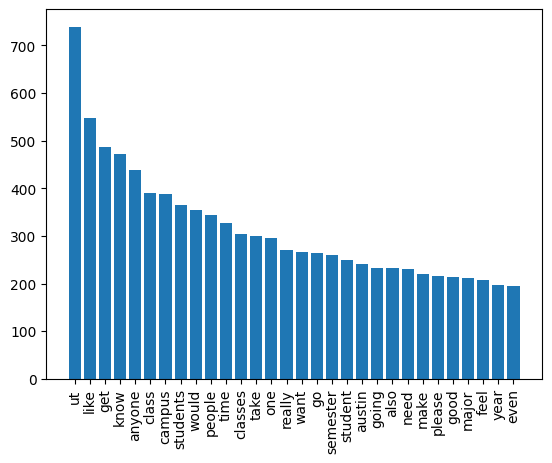

In [147]:
import matplotlib.pyplot as plt

plt.bar(top100.word,top100.frequency)

a=plt.xticks(rotation=90)
plt.show()

In [131]:
website = re.compile("(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+")  ###Removes URLS
word_freq={}
for i in comments.Body:
    i=str(i)
    i=re.sub(r'http\S+','',i)
    msg=i.lower()
    msg=word_tokenize(str(i))
    msg=[i.lower() for i in msg if i.lower() not in stop_words and i.isalnum()]
    for word in msg:
        if word not in word_freq:
            word_freq[word]=1
        else:
            word_freq[word]+=1
freq_df_2=pd.DataFrame({"word": [i for i in word_freq.keys()], "frequency": [i for i in word_freq.values()]})
freq_df_2=freq_df_2.sort_values(by='frequency',ascending=False)
top100_2=freq_df_2.reset_index().drop('index',axis=1).head(100)

In [9]:
stemmer = SnowballStemmer("english")
remove_topcs=['https','texas','ut','texa','utexas','utaustin','reddit']
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in remove_topcs:
            result.append(lemmatize_stemming(token))
            
    return result

In [10]:
processed_docs = []

for doc in posts.text:
    processed_docs.append(preprocess(doc))

dictionary = gensim.corpora.Dictionary(processed_docs)

dictionary.filter_extremes(no_below=15, no_above=0.6, keep_n= 100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))                                                     

Word 2 ("come") appears 1 time.
Word 140 ("colleg") appears 1 time.


In [11]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dictionary,                                    
                                   passes = 250,
                                   workers = 4,
                                   eta=0.001)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.032*"like" + 0.024*"feel" + 0.024*"friend" + 0.022*"peopl" + 0.022*"know" + 0.020*"year" + 0.020*"want" + 0.019*"time" + 0.017*"go" + 0.015*"campus"


Topic: 1 
Words: 0.044*"campus" + 0.020*"know" + 0.017*"domino" + 0.017*"walk" + 0.016*"build" + 0.016*"today" + 0.014*"lose" + 0.013*"near" + 0.013*"peopl" + 0.013*"think"


Topic: 2 
Words: 0.058*"class" + 0.023*"major" + 0.022*"semest" + 0.021*"student" + 0.020*"like" + 0.017*"cours" + 0.017*"take" + 0.017*"professor" + 0.016*"know" + 0.013*"want"


Topic: 3 
Words: 0.065*"student" + 0.041*"austin" + 0.026*"univers" + 0.020*"vote" + 0.016*"email" + 0.012*"elect" + 0.010*"start" + 0.010*"send" + 0.010*"say" + 0.010*"question"




Topic 0: peers/friends

Topic 1: campus

Topic 2: class_related

Topic 3: admin_related

In [12]:
def lda_res(x):    
    bow_vector=dictionary.doc2bow(preprocess(x))
    a=lda_model[bow_vector]
    lst=[]
    for i in a:
        lst.append(i[1])
    return lst

In [13]:
posts['LDA_scores']=posts['text'].apply(lambda x:lda_res(x))

In [14]:
lda_df=pd.DataFrame(posts["LDA_scores"].to_list(), columns=['college_peers', 'campus','class_related','admin_related'])

In [15]:
final_df=pd.merge(posts,lda_df,left_index=True,right_index=True)

In [16]:
final_df['college_peers']=final_df['college_peers'].fillna(0)
final_df['campus']=final_df['campus'].fillna(0)
final_df['class_related']=final_df['class_related'].fillna(0)
final_df['admin_related']=final_df['admin_related'].fillna(0)

In [17]:
sentiment=SentimentIntensityAnalyzer()
# setting words that are associated with games to 0 so they don't influence sentiment scores

# function to get sentiment for a review - we take the average of each sentence's sentiment to improve performance
def get_sent(text):
    scores=[]
    text=str(text).lower()
    clean_text=[lemmatize_stemming(word) for word in text.split() if word not in stop_words]
    clean_text=' '.join(e for e in clean_text)
    for sent in sent_tokenize(text):
        scores.append(sentiment.polarity_scores(sent)['compound'])

    return np.mean(scores)

In [18]:
final_df['sentiment_headline']=final_df['text'].apply(lambda x:get_sent(x))

In [19]:
comments['sentiment']=comments['Body'].apply(lambda x:get_sent(x))
comments['sentiment_agg']=comments['sentiment']*comments['Score']

In [20]:
import spacy
from collections import Counter
from string import punctuation
nlp = spacy.load("en_core_web_sm")
def get_hotwords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] 
    doc = nlp(text.lower()) 
    for token in doc:
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            result.append(token.text)
    
    most_common_list=Counter(set(result)).most_common(10)
    return most_common_list


In [21]:
comm_concat=comments.groupby(['Post ID'])['Body'].apply(lambda x: ' '.join(x)).reset_index()
comm_concat['top_words']=comm_concat['Body'].apply(lambda x:get_hotwords(x))

In [22]:
comments_agg=comments.groupby(['Post ID']).agg({'sentiment_agg':'mean'}).reset_index()

In [78]:
comments_fnl=pd.merge(comm_concat,comments_agg,left_on='Post ID',right_on='Post ID').\
    rename({'top_words':'top_words_comments','sentiment_agg':'sentiment_comm_agg'},axis=1)

In [28]:
final_df['top_topic']=final_df[['college_peers', 'campus', 'class_related','admin_related']].idxmax(axis=1)

In [79]:
comments_fnl=comments_fnl.drop(['Body'],axis=1)
comments_fnl=comments_fnl[~(comments_fnl['top_words_comments'].apply(lambda x:len(x))==0)].reset_index().drop(['index'],axis=1)

In [85]:
comments_fnl['top_words_comments']=comments_fnl['top_words_comments'].apply(lambda x:','.join(list(zip(*x))[0]))

In [86]:
final_df_1=pd.merge(comments_fnl,final_df,left_on='Post ID',right_on='ID')

In [87]:
final_df_1.to_csv("df.csv")

In [97]:
final_df_1.columns

Index(['Post ID', 'top_words_comments', 'sentiment_comm_agg', 'Title',
       'Post Text', 'ID', 'Score', 'Total Comments', 'Post URL', 'text',
       'LDA_scores', 'college_peers', 'campus', 'class_related',
       'admin_related', 'sentiment_headline', 'top_topic'],
      dtype='object')

In [121]:
comm=final_df_1[final_df_1['sentiment_comm_agg']<-5]['top_words_comments'].to_list()
comm=[i.split(',') for i in comm]

In [122]:
Counter([item for sublist in comm for item in sublist]).most_common(20)

[('time', 10),
 ('utaustin', 7),
 ('sorry', 5),
 ('bro', 4),
 ('action', 4),
 ('class', 4),
 ('shit', 3),
 ('graduate', 3),
 ('ut', 3),
 ('austin', 2),
 ('block', 2),
 ('ground', 2),
 ('orange', 2),
 ('longhorn', 2),
 ('group', 2),
 ('second', 2),
 ('vibe', 2),
 ('study', 2),
 ('money', 2),
 ('friend', 2)]

In [100]:
final_df_1[final_df_1['sentiment_comm_agg']>5].groupby(['top_topic']).agg({'ID':'count'})

,ID
top_topic,
admin_related,17
campus,48
class_related,22
college_peers,46
